In [150]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [151]:
connection = sqlite3.connect('../data/checking-logs.sqlite')

In [152]:
pd.io.sql.read_sql("PRAGMA table_info(checker);", connection)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,status,TEXT,0,None,0
2,2,success,INTEGER,0,None,0
3,3,timestamp,TIMESTAMP,0,None,0
4,4,numTrials,INTEGER,0,None,0
5,5,labname,TEXT,0,None,0
6,6,uid,TEXT,0,None,0


In [153]:
pd.io.sql.read_sql('SELECT * FROM checker LIMIT 10;', connection)

,index,status,success,timestamp,numTrials,labname,uid
0,0,checking,0,2020-04-16 21:12:50.740474,5,None,admin_1
1,1,ready,0,2020-04-16 21:12:54.708365,5,code_rvw,admin_1
2,2,checking,0,2020-04-16 21:46:47.769088,7,None,admin_1
3,3,ready,0,2020-04-16 21:46:48.121217,7,lab02,admin_1
4,4,checking,0,2020-04-16 21:53:01.862637,6,code_rvw,admin_1
5,5,ready,0,2020-04-16 21:53:05.373389,6,code_rvw,admin_1
6,6,checking,0,2020-04-17 05:18:51.965864,1,None,None
7,7,ready,0,2020-04-17 05:19:02.744528,1,project1,user_4
8,8,checking,0,2020-04-17 05:22:35.249331,2,project1,user_4
9,9,ready,1,2020-04-17 05:22:45.549397,2,project1,user_4


In [154]:
query = """
WITH 
first_submissions AS (
    SELECT uid, labname, MIN(timestamp) as first_commit_time
    FROM checker
    WHERE 
        labname != 'project1'
        AND uid LIKE 'user_%'
    GROUP BY uid, labname
),

avg_time_differences AS (
    SELECT 
        fc.uid,
        AVG(cast((JULIANDAY(fc.first_commit_time) - JULIANDAY(datetime(d.deadlines, 'unixepoch'))) * 24 AS INT)) AS avg_diff,
        COUNT(DISTINCT fc.labname) as commit_count
    FROM first_submissions fc
    JOIN deadlines d ON fc.labname = d.labs
    GROUP BY fc.uid
),

total_commits AS (
    SELECT uid, COUNT(*) as num_commits
    FROM checker
    WHERE labname != 'project1'
    GROUP BY uid
),

total_pageviews AS (
    SELECT uid, COUNT(*) as pageviews
    FROM pageviews
    GROUP BY uid
)

SELECT atd.uid, atd.avg_diff, tp.pageviews, tc.num_commits
FROM avg_time_differences atd
JOIN total_commits tc ON atd.uid = tc.uid
JOIN total_pageviews tp ON atd.uid = tp.uid
"""

In [155]:
df = pd.read_sql(query, connection)
df

,uid,avg_diff,pageviews,num_commits
0,user_1,-64.400000,28,62
1,user_10,-74.800000,89,20
2,user_14,-159.000000,143,61
3,user_17,-61.600000,47,51
4,user_18,-5.666667,3,5
5,user_19,-98.750000,16,118
6,user_21,-95.500000,10,65
7,user_25,-92.600000,179,79
8,user_28,-86.400000,149,60
9,user_3,-105.400000,317,18


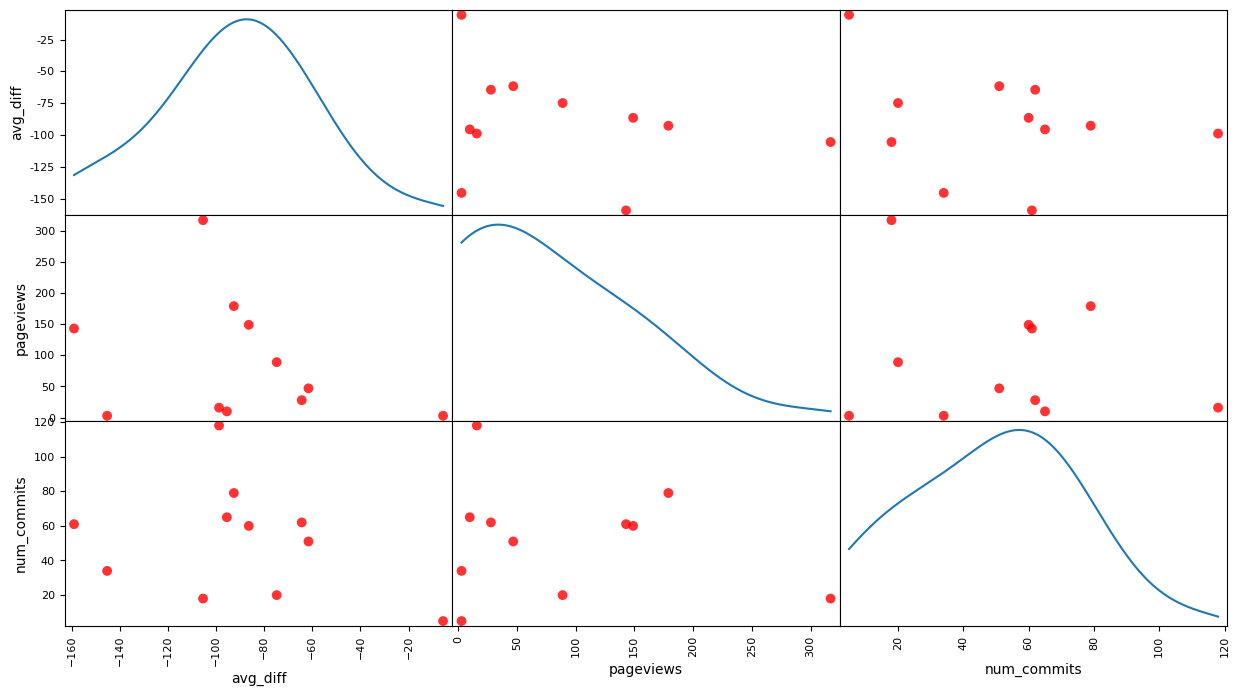

In [156]:
x = scatter_matrix(
    df[['avg_diff', 'pageviews', 'num_commits']],
    figsize=(15, 8),
    diagonal='kde',
    color='red',
    s=200,
    linewidth=3,
    alpha=0.8    
)

## 1. Можно ли сказать, что если у пользователя мало просмотров страниц, то, вероятно, у него мало и коммитов?

### Ответ: нет
#### На графике pageviews vs num_commits не образуют четкой восходящей линии
#### Если смотреть данные, то user_19 (16 views, 118 commits) и user_1 (28 views, 62 commits) показывают, что даже при относительно малом числе просмотров может быть много коммитов

## 2. Можно ли сказать, что если у пользователя мало просмотров страниц, то, скорее всего, средняя разница между первым коммитом и крайним сроком выполнения лабораторной работы будет небольшой?

### Ответ: нет
#### На графике avg_diff vs pageviews точки разбросаны хаотично
#### Есди смотреть данные, то user_30 (3 views, avg_diff=-145.25) и user_18 (3 views, avg_diff=-5.67) демонстрируют, что при одинаково малом числе просмотров разница времени сдачи может сильно варьироваться

## 3. Можно ли сказать, что есть много пользователей с малым количеством коммитов и несколько с большим количеством коммитов?

### Ответ: да
#### Распределение num_commits правосторонне-скошенное: большинство значений сосредоточено в левой части (малые значения), а user_19 (118 commits) и user_1 (62 commits) — выбросы в правой части

## 4. Можно ли сказать, что есть много пользователей с небольшой средней разницей и несколько пользователей с большой средней разницей?

### Ответ: нет
#### Нет явного доминирования "центральной" группы
#### Если бы было много пользователей с небольшой разницей и несколько с большой, распределение avg_diff выглядело бы, как "длинный хвост" в одну сторону

In [157]:
connection.close()